## Import library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import copy
import time
import random
from tqdm.notebook import tqdm

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

import os
os.environ['PATH'] += os.pathsep + '/home/jupyter-23522024/.local/bin'

## Setup dataset

In [2]:
# pip install kaggle

In [3]:
# !pip install --upgrade --quiet kaggle
# !which kaggle
# !pip show kaggle
# !ls /home/jupyter-23522024/.local/bin

In [4]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [5]:
# !kaggle datasets download -d andrewmvd/animal-faces
# !unzip animal-faces.zip -d animal_faces_dataset

## EDA

### Show image samples

In [6]:
def show_images_from_each_class(data_dir, num_images=3):
    classes = os.listdir(data_dir)
    plt.figure(figsize=(20, 10))
    
    for i, cls in enumerate(classes):
        cls_path = os.path.join(data_dir, cls)
        imgs = [f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        selected_imgs = random.sample(imgs, num_images)
        
        for j, img_file in enumerate(selected_imgs):
            img_path = os.path.join(cls_path, img_file)
            img = mpimg.imread(img_path)
            plt.subplot(len(classes), num_images, i * num_images + j + 1)    # plt.subplot(row, column, position)
            plt.imshow(img)
            plt.title(f'{cls}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

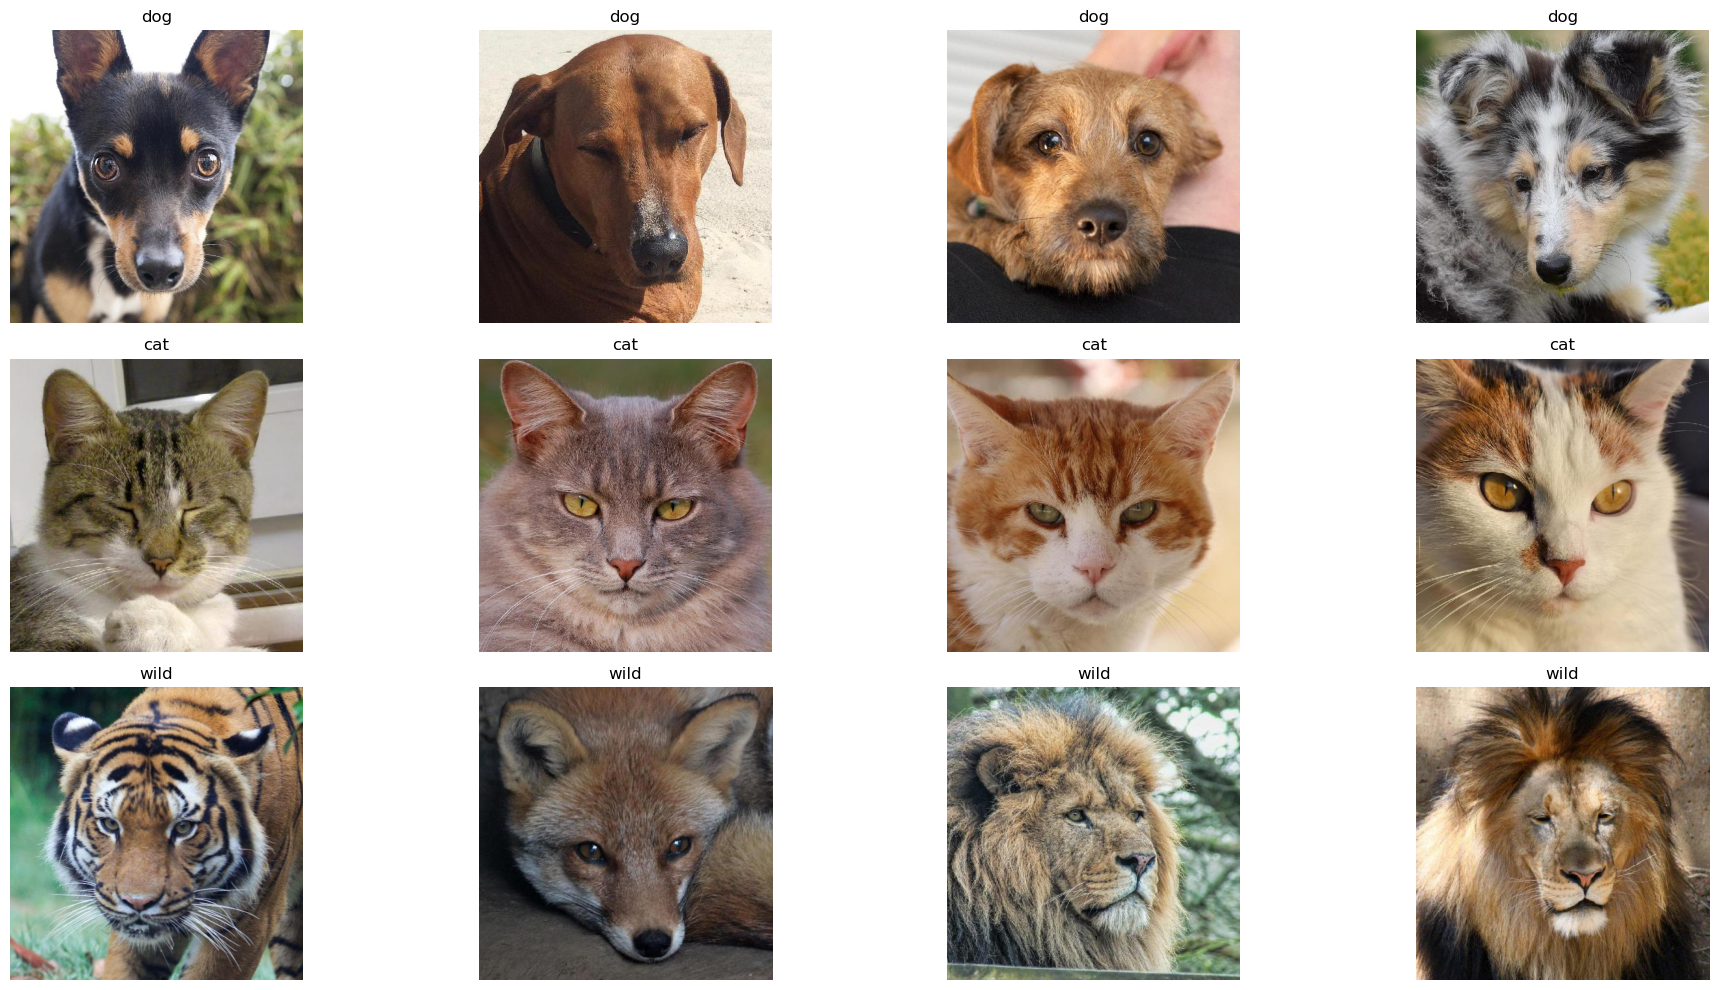

In [7]:
base_dir = 'animal_faces_dataset'
show_images_from_each_class(f"{base_dir}/train", num_images=4)

### Class distribution

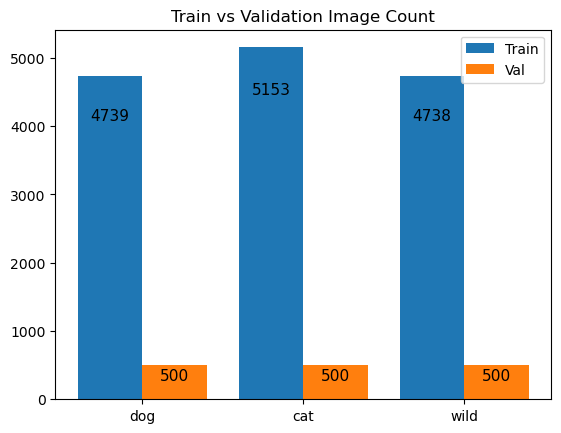

In [8]:
def count_images_in_dir(data_dir):
    counts = {}
    for cls in os.listdir(data_dir):
        cls_path = os.path.join(data_dir, cls)
        counts[cls] = len(os.listdir(cls_path))
    return counts

train_counts = count_images_in_dir(f"{base_dir}/train")
val_counts = count_images_in_dir(f"{base_dir}/val")

# Plot
labels = train_counts.keys()
x = range(len(labels))

bars_train = plt.bar(x, train_counts.values(), width=0.4, label='Train', align='center')
bars_val = plt.bar([i + 0.4 for i in x], val_counts.values(), width=0.4, label='Val', align='center')
plt.xticks([i + 0.2 for i in x], labels)
plt.title("Train vs Validation Image Count")
plt.legend()

# Add count labels on top of each bar
for bar in bars_train:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height - 0.1 * height, 
             f'{int(height)}', ha='center', va='top', color='black', fontsize=11)
    
for bar in bars_val:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height - 0.1 * height,
             f'{int(height)}', ha='center', va='top', color='black', fontsize=11)
    
plt.show()

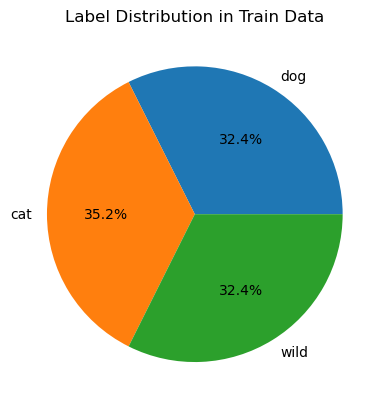

In [9]:
labels = 'Dog', 'Cat', 'Wildlife'
sizes = [15, 30, 45, 10]

fig, ax = plt.subplots()
ax.pie(train_counts.values(), labels=train_counts.keys(), autopct='%1.1f%%')
plt.title("Label Distribution in Train Data")
plt.show()

## Build the model

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Data preprocessing
- Resize to 224x224 because models like ResNet and EfficientNet (B0) expect inputs to be 224×224 images by default
- Augmentation by flipping the image
- Converts from numpy array to tensor
- Normalizes each pixel value to be in the range [-1, 1] instead of [0, 1]

In [11]:
# Transform
transform_train = transforms.Compose([   #  combines a sequence of image transformations into a pipeline
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)   # [0.5]*3 means apply the same mean to all 3 channels (RGB)
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)   
])

In [12]:
# ImageFolder used for:
# - It reads images inside cat/, dog/, wild/ subfolders under train/
# - It automatically labels them as: cat: 0, dog: 1, wild: 2
# - It applies the transform_train to each image. So each sample in train_dataset becomes a (image_tensor, label) pair

train_dataset = datasets.ImageFolder(f'{base_dir}/train', transform=transform_train)
val_dataset = datasets.ImageFolder(f'{base_dir}/val', transform=transform_val)

# train_subset = Subset(train_dataset, range(0, 1000))
# val_subset = Subset(val_dataset, range(0, 200))

# DataLoader wraps a dataset:
# - Batches data (e.g., 32 images at a time)
# - Shuffles the data if needed
# - Enables efficient batch training and simplifies looping over the data

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)

In [13]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, model_name="model"):
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_acc': best_acc,
        'history': history
    }
    
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        train_correct, train_total, train_loss = 0, 0, 0

        train_pbar = tqdm(train_loader, desc="Training", leave=False)
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)   # Forward pass → get predictions
            loss = criterion(outputs, labels)
            loss.backward()   # Compute gradients
            optimizer.step()   # Update weights

            # Calculate how many predictions are correct → for accuracy
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            train_pbar.set_postfix(loss=loss.item())   # Update progress bar with current loss

        train_acc = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_correct, val_total, val_loss = 0, 0, 0
        val_pbar = tqdm(val_loader, desc="Validating", leave=False)
        with torch.no_grad():
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f"{model_name}_best.pth")  # Save to disk
            print(f"✅ Best model updated: Val Acc = {val_acc:.4f}")
            
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        torch.save(checkpoint, f"{model_name}_epoch_{epoch}.pth")
        
    model.load_state_dict(best_model_wts)  # Load best weights before returning
    return model, history

In [14]:
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [15]:
EPOCHS = 10

### CNN

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)   # 3 channels (RGB), kernel size 3x3
        self.pool = nn.MaxPool2d(2, 2)   # Stride: 2 (halves the width and height)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   
        x = self.pool(F.relu(self.conv2(x)))   
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

| Layer   | Output Shape             | Description                    |
| ------- | ------------------------ | ------------------------------ |
| Conv1   | \[32, 224, 224]          | 3x3 conv                       |
| Pool1   | \[32, 112, 112]          | 2x2 max pooling                |
| Conv2   | \[64, 112, 112]          | 3x3 conv                       |
| Pool2   | \[64, 56, 56]            | 2x2 max pooling                |
| Flatten | \[64 × 56 × 56 = 200704] | Flatten before FC              |
| FC1     | \[256]                   | Dense layer                    |
| FC2     | \[num\_classes]          | Output logits (before softmax) |

In [17]:
cnn_model = SimpleCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=1e-4)

In [18]:
start_time = time.time()
cnn_model, cnn_history = train_model(cnn_model, criterion, optimizer_cnn, train_loader, 
                                     val_loader, num_epochs=EPOCHS, model_name="cnn")
cnn_time = time.time() - start_time


Epoch 1/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

✅ Best model updated: Val Acc = 0.8927
Train Acc: 0.8146, Val Acc: 0.8927

Epoch 2/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

✅ Best model updated: Val Acc = 0.9100
Train Acc: 0.9215, Val Acc: 0.9100

Epoch 3/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

✅ Best model updated: Val Acc = 0.9153
Train Acc: 0.9459, Val Acc: 0.9153

Epoch 4/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

✅ Best model updated: Val Acc = 0.9393
Train Acc: 0.9586, Val Acc: 0.9393

Epoch 5/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9679, Val Acc: 0.9300

Epoch 6/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

✅ Best model updated: Val Acc = 0.9533
Train Acc: 0.9774, Val Acc: 0.9533

Epoch 7/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9823, Val Acc: 0.9393

Epoch 8/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9862, Val Acc: 0.9487

Epoch 9/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9923, Val Acc: 0.9507

Epoch 10/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

✅ Best model updated: Val Acc = 0.9540
Train Acc: 0.9930, Val Acc: 0.9540


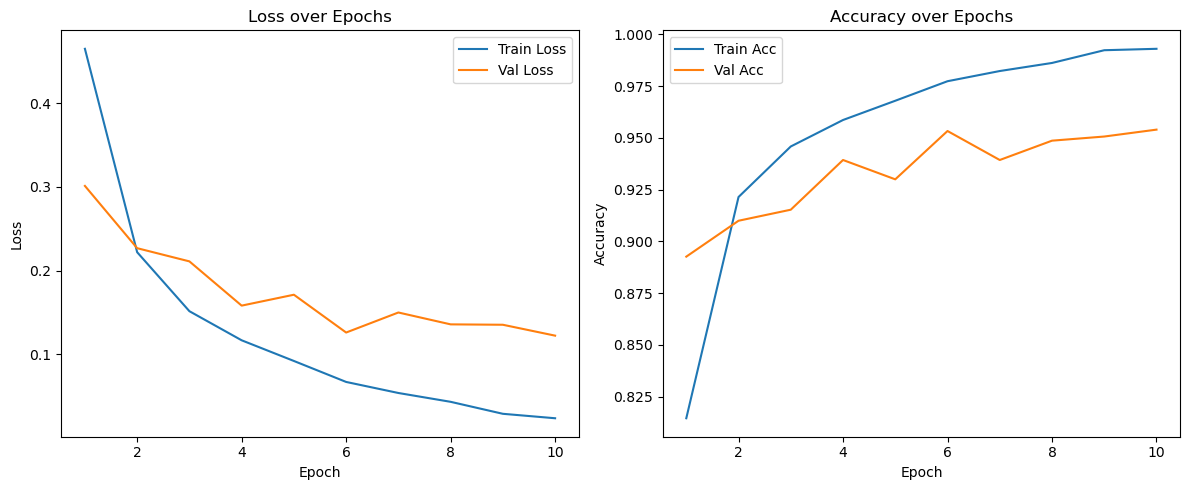

In [19]:
plot_training_curves(cnn_history)

### ResNet50

In [20]:
resnet_model = models.resnet50(pretrained=True)

# resnet_model.fc is the final fully-connected (FC) layer of ResNet-50.
# By default, it outputs 1000 classes (ImageNet).
# Replace it with a new FC layer:
# Input: resnet_model.fc.in_features → the output from the previous layer (usually 2048).
# Output: num_classes → e.g., 3 for your dataset (cat, dog, wild)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# Adam: adaptive optimizer that's generally better than SGD for fine-tuning.
# resnet_model.parameters(): training all parameters of the model (can be limited if you want to freeze some layers).
# lr=1e-4: small learning rate, since we're fine-tuning a pre-trained model (we don’t want to drastically change the weights).
optimizer_resnet = torch.optim.Adam(resnet_model.parameters(), lr=1e-4) # Training all parameters of the model 

/opt/tljh/user/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/tljh/user/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
start_time = time.time()
resnet_model, resnet_history = train_model(resnet_model, criterion, optimizer_resnet, train_loader, 
                                           val_loader, num_epochs=EPOCHS, model_name="resnet")
resnet_time = time.time() - start_time


Epoch 1/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

✅ Best model updated: Val Acc = 0.9967
Train Acc: 0.9889, Val Acc: 0.9967

Epoch 2/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9951, Val Acc: 0.9933

Epoch 3/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

✅ Best model updated: Val Acc = 0.9987
Train Acc: 0.9975, Val Acc: 0.9987

Epoch 4/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9967, Val Acc: 0.9987

Epoch 5/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9979, Val Acc: 0.9973

Epoch 6/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9994, Val Acc: 0.9960

Epoch 7/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9965, Val Acc: 0.9980

Epoch 8/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9992, Val Acc: 0.9980

Epoch 9/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9979, Val Acc: 0.9987

Epoch 10/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9986, Val Acc: 0.9947


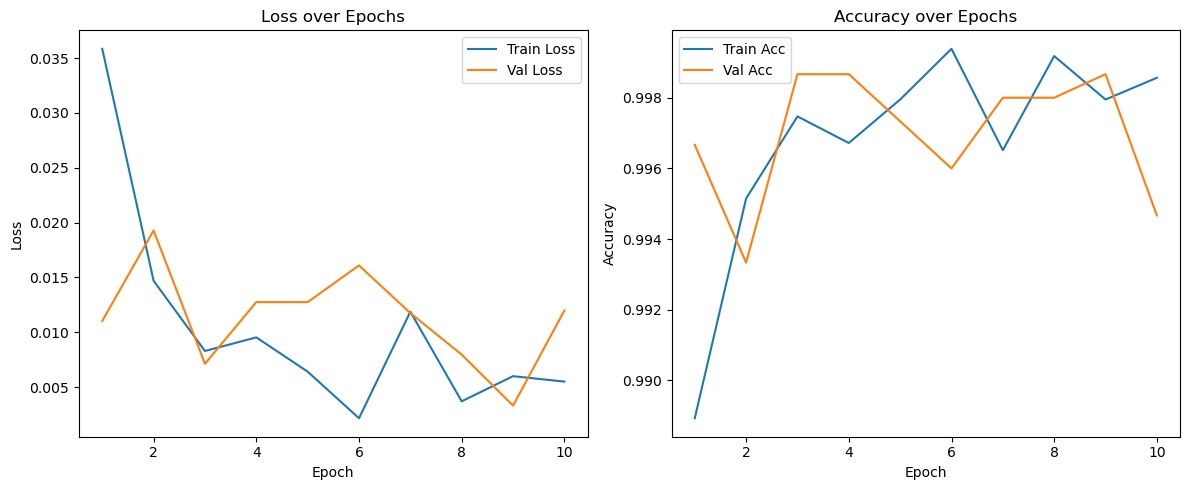

In [22]:
plot_training_curves(resnet_history)

### EfficientNet

| Model        | Final Layer Path             | Replaced By                                                      |
| ------------ | ---------------------------- | ---------------------------------------------------------------- |
| ResNet-50    | `resnet_model.fc`            | `nn.Linear(resnet_model.fc.in_features, num_classes)`            |
| EfficientNet | `effnet_model.classifier[1]` | `nn.Linear(effnet_model.classifier[1].in_features, num_classes)` |

EfficientNet is usually more parameter-efficient and faster than ResNet for similar accuracy.

In [23]:
effnet_model = models.efficientnet_b0(pretrained=True)
effnet_model.classifier[1] = nn.Linear(effnet_model.classifier[1].in_features, num_classes)
optimizer_effnet = torch.optim.Adam(effnet_model.parameters(), lr=1e-4)

/opt/tljh/user/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
start_time = time.time()
effnet_model, effnet_history = train_model(effnet_model, criterion, optimizer_effnet, train_loader, 
                                           val_loader, num_epochs=EPOCHS, model_name="effnet")
effnet_time = time.time() - start_time


Epoch 1/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

✅ Best model updated: Val Acc = 0.9973
Train Acc: 0.9796, Val Acc: 0.9973

Epoch 2/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

✅ Best model updated: Val Acc = 0.9987
Train Acc: 0.9972, Val Acc: 0.9987

Epoch 3/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9977, Val Acc: 0.9987

Epoch 4/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9986, Val Acc: 0.9987

Epoch 5/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9981, Val Acc: 0.9973

Epoch 6/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9984, Val Acc: 0.9980

Epoch 7/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9985, Val Acc: 0.9973

Epoch 8/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9997, Val Acc: 0.9967

Epoch 9/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9992, Val Acc: 0.9980

Epoch 10/10


Training:   0%|          | 0/458 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Acc: 0.9998, Val Acc: 0.9980


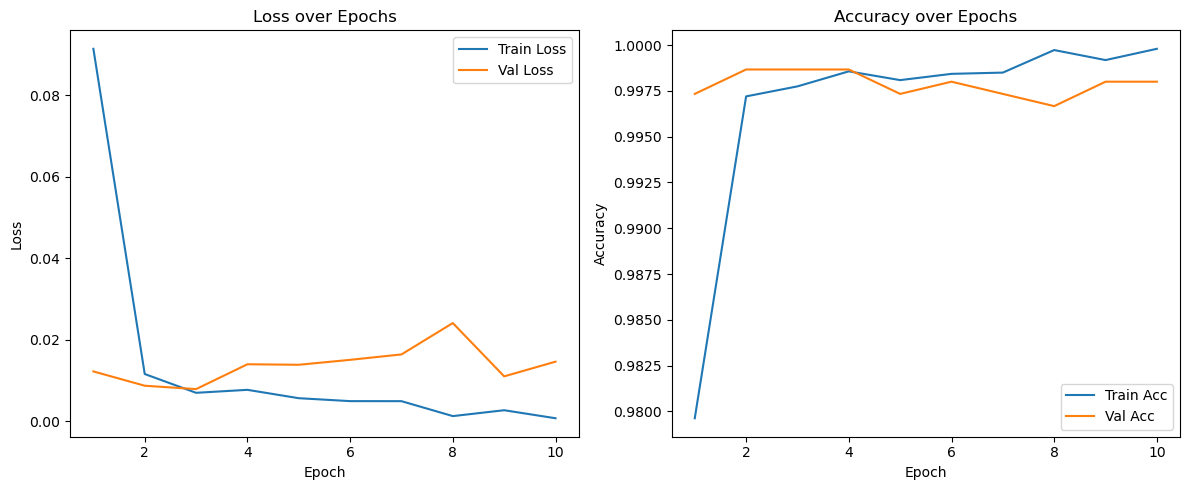

In [25]:
plot_training_curves(effnet_history)

## Results comparison

In [26]:
results_df = pd.DataFrame({
    'Model': ['Custom CNN', 'ResNet', 'EfficientNet'],
    'Final Validation Accuracy': [
        cnn_history['val_acc'][-1],
        resnet_history['val_acc'][-1],
        effnet_history['val_acc'][-1]
    ],
    'Training Time (s)': [cnn_time, resnet_time, effnet_time]
})

results_df

,Model,Final Validation Accuracy,Training Time (s)
0,Custom CNN,0.954000,11375.598552
1,ResNet,0.994667,6726.123722
2,EfficientNet,0.998000,6952.344628


- Custom CNN: Slower and lower accuracy, but still good for a basic model
- ResNet:	Great balance of speed and performance
- EfficientNet: Best accuracy overall



✅ Insights:
- Transfer learning with pretrained models like ResNet and EfficientNet clearly outperforms training CNN from scratch.
- EfficientNet-B0 gives slightly better accuracy than ResNet, with comparable training time.
- CNN still performs well, so it's a good baseline.

## Inference

In [38]:
from PIL import Image

# Same transform used for validation/training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def predict_image(image_path, model, class_names):
    img_arr = Image.open(image_path).convert('RGB')
    input_tensor = transform(img_arr).unsqueeze(0).to(device)  # Add batch dimension
    
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class}")
    
    plt.tight_layout()
    plt.show()
    
    return predicted_class


In [39]:
# Load model
effnet_model = models.efficientnet_b0(pretrained=False) # set pretrained=False to avoid overwriting weights
effnet_model.classifier[1] = nn.Linear(effnet_model.classifier[1].in_features, num_classes)

effnet_model.load_state_dict(torch.load('effnet_best.pth'))
effnet_model.to(device)
effnet_model.eval()

# Define class names in the same order as your training set folder
class_names = ['Cat', 'Dog', 'Wild']

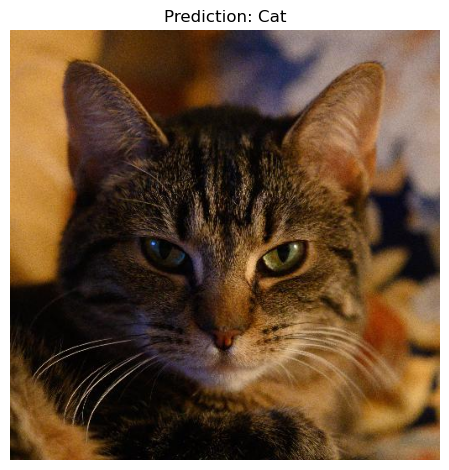

In [41]:
image_path = "animal_faces_dataset/val/cat/flickr_cat_000011.jpg"
prediction = predict_image(image_path, effnet_model, class_names)
